### Necessary imports

In [1]:
import torch
import numpy as np
from torch import nn
from time import time
from capsules import *
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

### Definition of CapsNet model

In [2]:
class CapsNet4AD(nn.Module):
    
    def __init__(self):
        super(CapsNet4AD, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=256,
                kernel_size=9,
                stride=1
            ),
            nn.ReLU(inplace=True)
        )
        self.primcaps = PrimaryCapsuleLayer()
        self.digicaps = SecondaryCapsuleLayer(n_capsules=2)
        self.decoder = RegularizingDecoder(dims=[32,512,1024,784])
        
    def forward(self, x):
        """Compute forward of capsules, get the longest vectors, reconstruct the pictures"""
        u = self.conv(x)
        u = self.primcaps(u)
        internal = self.digicaps(u)
        lengths = (internal**2).sum(dim=-1)**0.5
        _, max_caps_index = lengths.max(dim=-1)
        masked = Variable(torch.eye(2))
        masked = masked.cuda() if torch.cuda.is_available() else masked
        masked = masked.index_select(dim=0, index=max_caps_index)
        reconstruction = self.decoder(
            (internal*masked[:,:,None]).view(x.size(0), -1)
        )
        return(internal, reconstruction, lengths, max_caps_index)

In [3]:
cn = CapsNet4AD().cuda()
optimizer = Adam(cn.parameters())
capsule_loss = CapsuleLoss(normal_class=0, only_normals=True).cuda()

### Data processing

In [2]:
%%bash
git clone https://github.com/sorki/python-mnist.git
cd python-mnist/
./get_data.sh

~/HDD/works/Skoltech/CapsuleAD/src/capsules/python-mnist/data ~/HDD/works/Skoltech/CapsuleAD/src/capsules/python-mnist
~/HDD/works/Skoltech/CapsuleAD/src/capsules/python-mnist


Cloning into 'python-mnist'...
--2020-01-12 18:54:42--  http://yann.lecun.com/exdb/mnist/
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29170 (28K) [text/html]
Saving to: ‘data/index.html.tmp’

     0K .......... .......... ........                        100% 14,0M=0,002s

2020-01-12 18:54:43 (14,0 MB/s) - ‘data/index.html.tmp’ saved [29170/29170]

Loading robots.txt; please ignore errors.
--2020-01-12 18:54:43--  http://yann.lecun.com/robots.txt
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 404 Not Found
2020-01-12 18:54:43 ERROR 404: Not Found.

Removing data/index.html.tmp since it should be rejected.

--2020-01-12 18:54:43--  http://yann.lecun.com/
Reusing existing connection to yann.lecun.com:80.
HTTP request sent, awaiting response... 200 OK
Length: 38324 (37K) [text/html]
Saving to: ‘data/inde

In [3]:
from mnist import MNIST
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
test_img, test_lab = mndata.load_testing()

In [6]:
images = np.array(images)
labels = np.array(labels)
test_img = np.array(test_img)
test_lab = np.array(test_lab)

In [7]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [8]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [9]:
normal = images[labels == 0]
anomaly_index = np.random.choice(np.arange(images[labels != 0].shape[0]), 100)
anomaly = images[labels != 0][anomaly_index]
anomaly_labels = labels[labels != 0][anomaly_index]
anomaly_labels[anomaly_labels != 0] = 1

In [10]:
normal.shape, anomaly.shape

((5923, 784), (100, 784))

In [11]:
anomaly.shape[0]/(normal.shape[0]+anomaly.shape[0])

0.016603021749958494

In [12]:
normal_labels = np.array([0]*normal.shape[0])

In [13]:
AD_data = np.concatenate([normal, anomaly])
AD_labels = np.concatenate([normal_labels, anomaly_labels])

In [14]:
np.unique(AD_labels, return_counts=True)

(array([0, 1]), array([5923,  100]))

In [15]:
test_lab_AD = test_lab.copy()
test_lab_AD[test_lab_AD != 0] = 1

### Training

In [16]:
n_epochs = 10

In [17]:
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []
start_time = time()
for epoch in range(n_epochs):
    print("Epoch #"+str(epoch))
    cn.train()
    running_loss = []
    running_accuracy = []
    i = 0
    epoch_time = time()
    for batch_X, batch_y in iterate_minibatches(AD_data, AD_labels, 100):
        if i % 100 == 0:
            print("Minibatch "+str(i)+" of "+str(round(AD_data.shape[0]/100)))
        i += 1
        optimizer.zero_grad()
        inp = Variable(
            torch.from_numpy(
                batch_X.reshape(batch_X.shape[0],1,28,28)/255.0
            ).type(torch.FloatTensor)
        ).cuda()
        real_class = Variable(
            make_y(torch.from_numpy(batch_y).type(torch.LongTensor).cuda(), 2)
        )
        internal, reconstruction, classes, max_index = cn(inp)
        loss = capsule_loss(
            real_class, inp.view(inp.size(0), 28*28), classes, reconstruction
        )
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().data.numpy())
        running_accuracy.append(
            accuracy_score(max_index.cpu().data.numpy(), batch_y)
        )
    training_loss.append(np.mean(running_loss))
    training_accuracy.append(np.mean(running_accuracy))
    print("Training loss: "+str(training_loss[-1]))
    print("Training accuracy: "+str(training_accuracy[-1]))
    print("Training in "+str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
    cn.eval()
    running_test_loss = []
    running_test_accuracy = []
    i = 0
    for batch_X, batch_y in iterate_minibatches(test_img, test_lab_AD, 100):
        if i % 100 == 0:
            print("Testing minibatch "+str(i)+" of "+str(round(test_img.shape[0]/100)))
        i += 1
        test_X = Variable(
            torch.from_numpy(batch_X.reshape(batch_X.shape[0],1,28,28)/255.0).type(torch.FloatTensor)
        ).cuda()
        test_Y = Variable(
            make_y(torch.from_numpy(batch_y).type(torch.LongTensor).cuda(), 2)
        )
        test_internal, test_reconstruction, test_classes, test_ind = cn(test_X)
        #test_classes = test_classes.type(torch.cuda.FloatTensor)
        running_test_loss.append(
            capsule_loss(
                test_Y, test_X.reshape(test_X.size(0), 28*28), 
                test_classes, test_reconstruction
            ).cpu().data.numpy()
        )
        running_test_accuracy.append(
            accuracy_score(test_ind.cpu().data.numpy(), batch_y)
        )
    testing_loss.append(np.mean(running_test_loss))
    testing_accuracy.append(np.mean(running_test_accuracy))
    print("Testing loss: "+str(testing_loss[-1]))
    print("Testing accuracy: "+str(testing_accuracy[-1]))
    print(str(epoch)+"th epoch took "+str((time() - epoch_time)/60) + " minutes")
print("All epochs took "+str((time() - start_time)/60) + " minutes")

Epoch #0
Minibatch 0 of 60
Training loss: 0.05982053
Training accuracy: 0.9821311475409836
Training in 0th epoch took 0.1209627111752828 minutes
Testing minibatch 0 of 100
Testing loss: 1.8966882
Testing accuracy: 0.7476999999999999
0th epoch took 0.1739330291748047 minutes
Epoch #1
Minibatch 0 of 60
Training loss: 0.028806008
Training accuracy: 0.9960655737704918
Training in 1th epoch took 0.11844486395517985 minutes
Testing minibatch 0 of 100
Testing loss: 1.6234992
Testing accuracy: 0.8042
1th epoch took 0.17403475443522134 minutes
Epoch #2
Minibatch 0 of 60
Training loss: 0.02561273
Training accuracy: 0.9985245901639344
Training in 2th epoch took 0.1209207018216451 minutes
Testing minibatch 0 of 100
Testing loss: 0.92616844
Testing accuracy: 0.8887000000000002
2th epoch took 0.17616461118062338 minutes
Epoch #3
Minibatch 0 of 60
Training loss: 0.021233315
Training accuracy: 0.9990163934426229
Training in 3th epoch took 0.11721510887145996 minutes
Testing minibatch 0 of 100
Testing 

Text(0.5, 1.0, 'Accuracy')

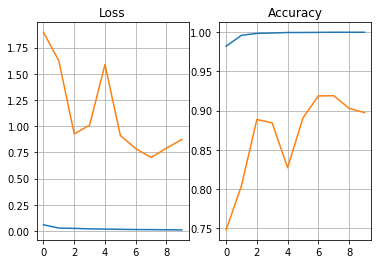

In [18]:
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.plot(testing_loss)
plt.grid(True)
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.grid(True)
plt.title("Accuracy")

In [19]:
torch.save(cn, "mnist_AD_capsule.ptch")

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CapsNet4AD. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
cn.eval()
random_normal = test_img[test_lab_AD==0][
    np.random.choice(range(test_img[test_lab_AD==0].shape[0]), 2)
]
random_anomaly = test_img[test_lab_AD==1][
    np.random.choice(range(test_img[test_lab_AD==1].shape[0]), 2)
]

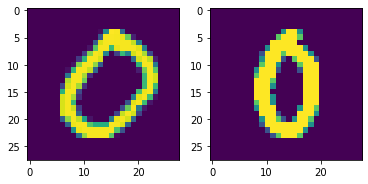

In [21]:
plt.subplot(1,2,1)
plt.imshow(random_normal[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(random_normal[1].reshape(28,28))

In [22]:
_,rec,_,cl = cn(Variable(torch.from_numpy(random_normal.reshape(2,1,28,28)/255).type(torch.FloatTensor)).cuda())

In [23]:
cl

tensor([0, 0], device='cuda:0')

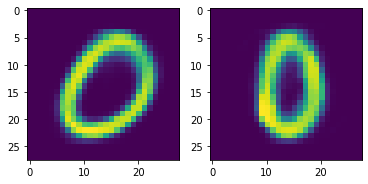

In [24]:
rec = rec.cpu().data.numpy()
plt.subplot(1,2,1)
plt.imshow(rec[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(rec[1].reshape(28,28))

In [25]:
_,rec,_,cl = cn(Variable(torch.from_numpy(random_anomaly.reshape(2,1,28,28)/255).type(torch.FloatTensor)).cuda())

In [26]:
cl

tensor([1, 1], device='cuda:0')

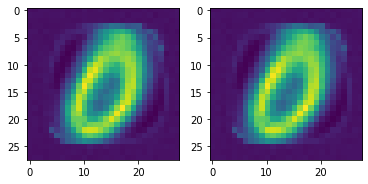

In [27]:
rec = rec.cpu().data.numpy()
plt.subplot(1,2,1)
plt.imshow(rec[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(rec[1].reshape(28,28))

In [28]:
d_inds = np.random.choice(np.arange(test_lab.shape[0]), 100)
d_imgs = test_img[d_inds]
d_lab = test_lab[d_inds]

In [29]:
np.unique(d_lab, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([11, 10, 13,  5, 13,  5, 12, 11,  9, 11]))

In [30]:
_,rec,lens,cl = cn(Variable(torch.from_numpy(d_imgs.reshape(100,1,28,28)/255).type(torch.FloatTensor)).cuda())

In [32]:
accuracy_score(test_lab_AD[d_inds], cl.cpu().data.numpy())

0.88

In [33]:
ln_diff, rec_loss = anomaly_scores(
    lens.cpu().data.numpy(), d_imgs, rec.cpu().data.numpy()
)

In [34]:
max_prob, norm_rec_loss = normality_scores(
    lens.cpu().data.numpy(), d_imgs, rec.cpu().data.numpy()
)

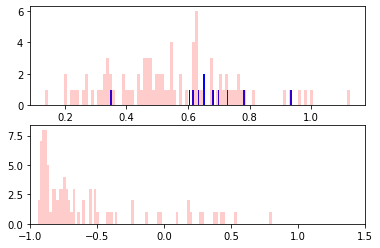

In [35]:
plt.subplot(2,1,1)
plt.hist(rec_loss[d_lab == 0], bins=100, color=(0,0,1,1))
plt.hist(rec_loss[test_lab_AD[d_inds] == 1], bins=100, color=(1,0,0,0.2))
plt.subplot(2,1,2)
plt.hist(ln_diff[d_lab == 0], bins=100, color=(0,0,1,1))
plt.hist(ln_diff[test_lab_AD[d_inds] == 1], bins=100, color=(1,0,0,0.2))
plt.xlim((-1,1.5))
plt.show()

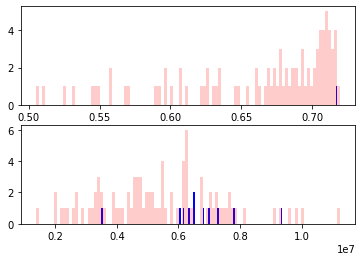

In [36]:
plt.subplot(2,1,1)
plt.hist(max_prob[d_lab == 0], bins=100, color=(0,0,1,1))
plt.hist(max_prob[test_lab_AD[d_inds] == 1], bins=100, color=(1,0,0,0.2))
plt.subplot(2,1,2)
plt.hist(norm_rec_loss[d_lab == 0], bins=100, color=(0,0,1,1))
plt.hist(norm_rec_loss[test_lab_AD[d_inds] == 1], bins=100, color=(1,0,0,0.2))
plt.show()